# Disease prediction based on drug reviews

## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import string
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)


In [2]:
df=pd.read_csv('drugsComTest_raw.csv')

In [3]:
df.head()

uniqueID         drugName                     condition  \
0    163740      Mirtazapine                    Depression   
1    206473       Mesalamine  Crohn's Disease, Maintenance   
2    159672          Bactrim       Urinary Tract Infection   
3     39293         Contrave                   Weight Loss   
4     97768  Cyclafem 1 / 35                 Birth Control   

                                              review  rating       date  \
0  "I&#039;ve tried a few antidepressants over th...      10  28-Feb-12   
1  "My son has Crohn&#039;s disease and has done ...       8  17-May-09   
2                      "Quick reduction of symptoms"       9  29-Sep-17   
3  "Contrave combines drugs that were used for al...       9   5-Mar-17   
4  "I have been on this birth control for one cyc...       9  22-Oct-15   

   usefulCount  
0           22  
1           17  
2            3  
3           35  
4            4

In [4]:
df.condition.value_counts()

condition
Birth Control                                                     9648
Depression                                                        3095
Pain                                                              2100
Anxiety                                                           1908
Acne                                                              1847
Bipolar Disorde                                                   1380
Weight Loss                                                       1248
Insomnia                                                          1231
Obesity                                                           1189
ADHD                                                              1126
Emergency Contraception                                            827
Vaginal Yeast Infection                                            811
Diabetes, Type 2                                                   808
High Blood Pressure                                                

In [5]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')]


In [6]:
df.shape

(53766, 7)

In [7]:
df_train.shape

(14334, 7)

In [8]:
X = df_train.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

## EDA

In [9]:
X.condition.value_counts()

condition
Birth Control          9648
Depression             3095
Diabetes, Type 2        808
High Blood Pressure     783
Name: count, dtype: int64

In [10]:
X.head()

condition                                             review
0      Depression  "I&#039;ve tried a few antidepressants over th...
4   Birth Control  "I have been on this birth control for one cyc...
6   Birth Control  "I&#039;ve had the copper coil for about 3 mon...
9   Birth Control  "I was on this pill for almost two years. It d...
30  Birth Control  "I absolutely love this product and recommend ...

In [11]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]

Text(0.5, 1.0, 'Word cloud for Birth control')

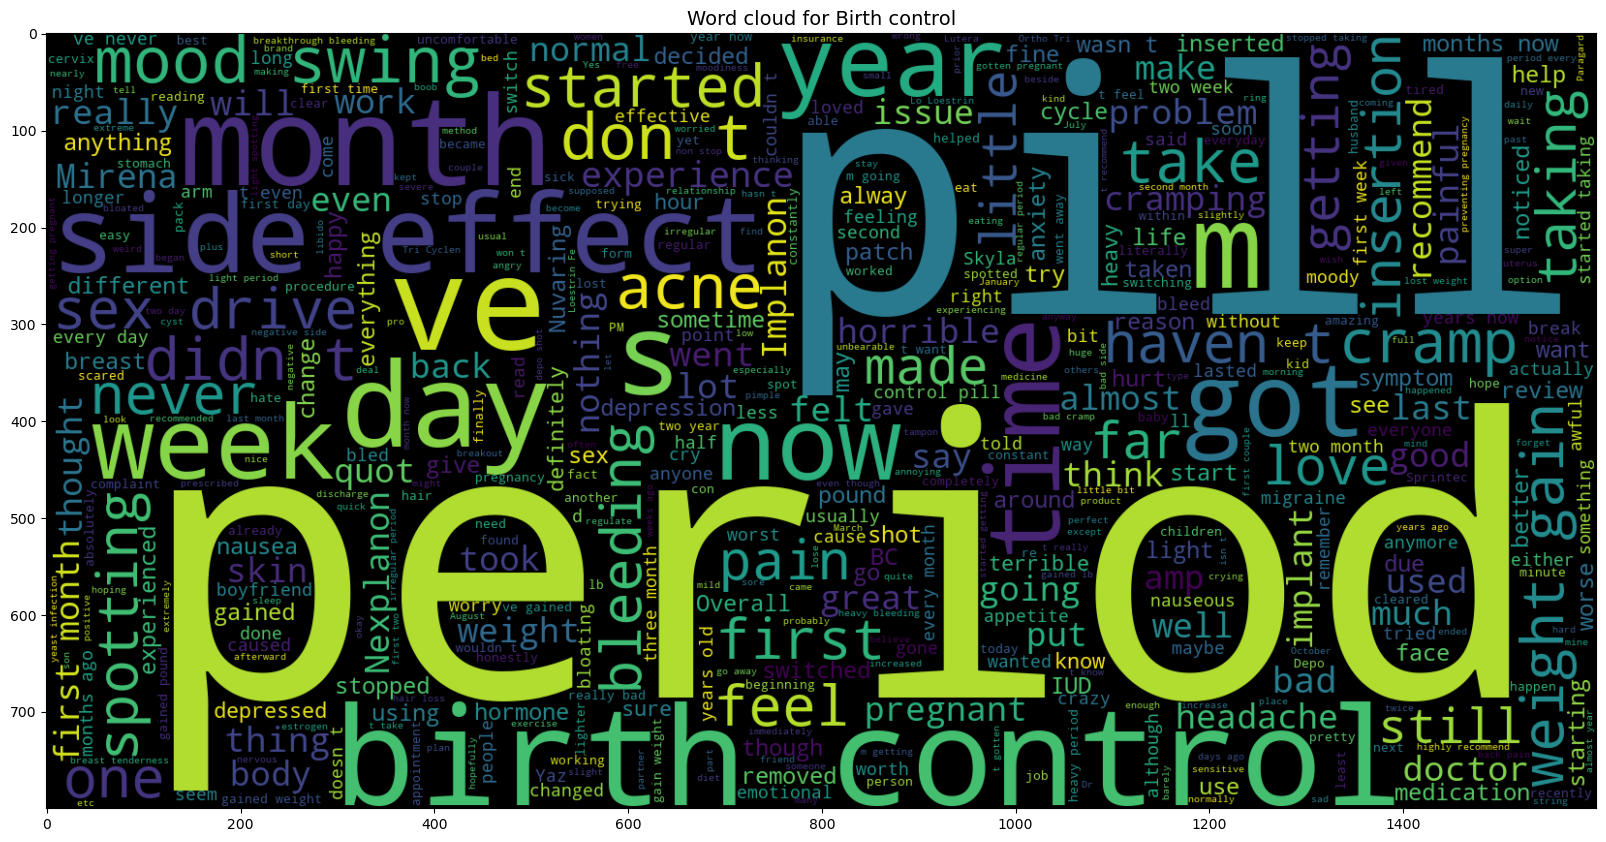

In [12]:
# !pip install wordcloud
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(list(X_birth.review)))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

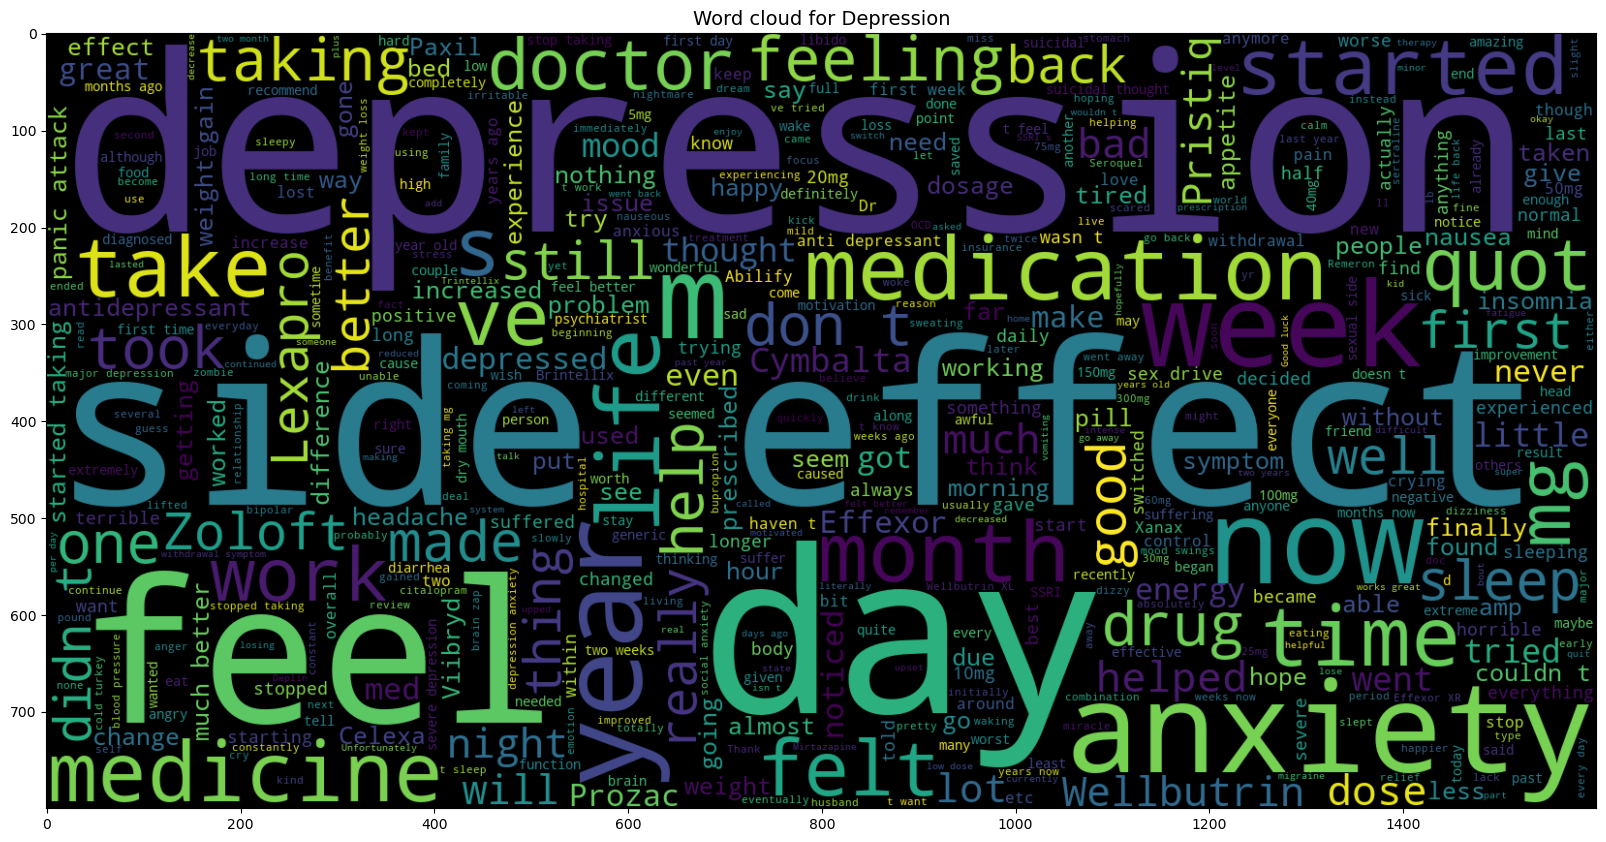

In [13]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

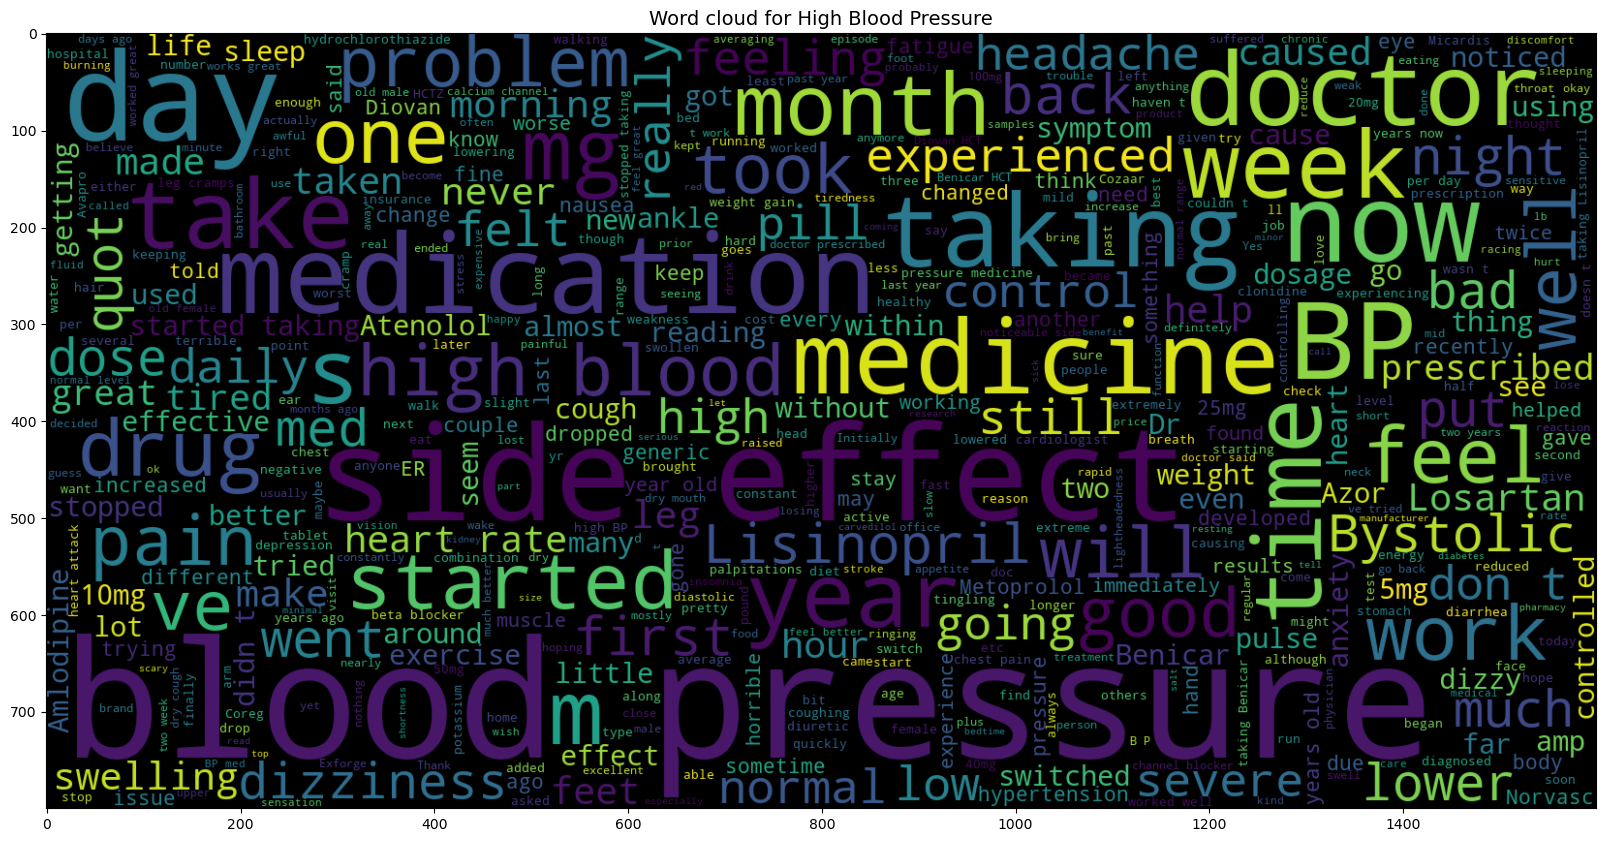

In [14]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

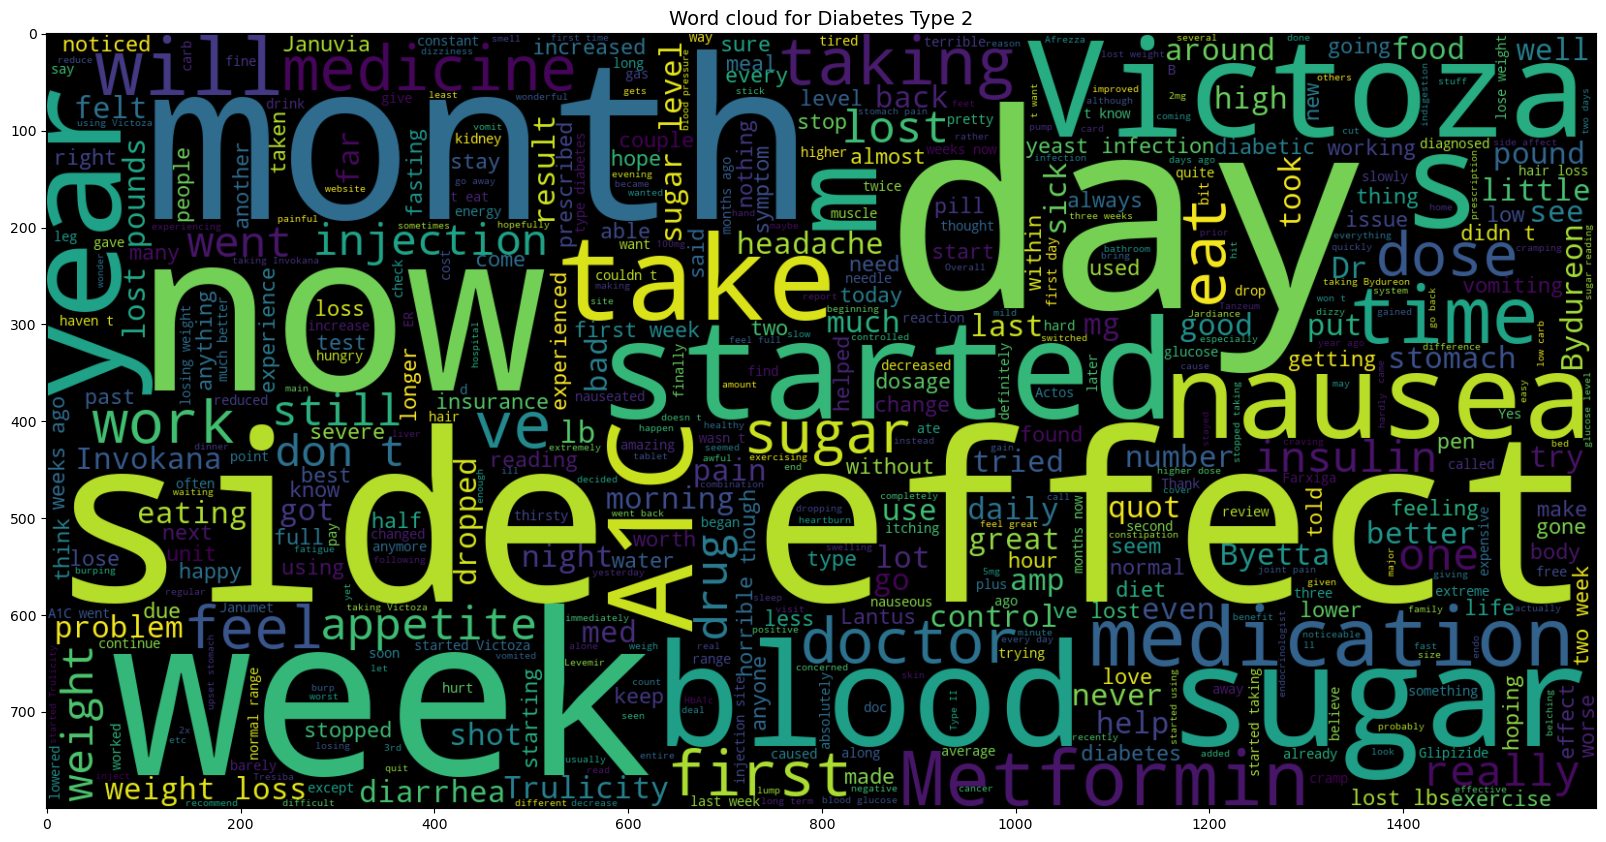

In [15]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

## data preprocessing

In [16]:
X['review'][4]

'"I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend"'

In [17]:
X['review'][9]

'"I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz."'

In [18]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [19]:
# To set the width of the column to maximum
pd.set_option('max_colwidth', None)

In [20]:
X.head()

condition  \
0      Depression   
4   Birth Control   
6   Birth Control   
9   Birth Control   
30  Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  
0                                                                                                                                                                                                                                                                                                                                      I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.  
4   I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend  
6                                                                                                                                                I&#039;ve had the copper coil for about 3 months now. I was really excited at the thought of not taking hormones. I&#039;m good with pain however I nearly fainted with insertion, couldn&#039;t belive how painful it was; the doctor did say it is very painful for some. Well 3 months in, my periods last 11 days and I&#039;m in pain for about 15 days with random twangs especially in the left side and I&#039;m considering whether I want to put up with the intense pain and heavy periods. I&#039;d recommend this 100% to somebody who doesn&#039;t already have heavy painful periods but right now it just isn&#039;t for me  
9                                                                                                                                                                                                                                                                                                       I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz.  
30                                            

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

## Lemmitization

In [23]:
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [24]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [25]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [26]:
#!pip install beautifulsoup4
from bs4 import BeautifulSoup
import re

In [27]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [28]:
X['review_clean'] = X['review'].apply(review_to_words)

C:\Users\devan\AppData\Local\Temp\ipykernel_2612\2066199760.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [29]:
X.head()

condition  \
0      Depression   
4   Birth Control   
6   Birth Control   
9   Birth Control   
30  Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
0                                                                                                                                                                                                                                                                                                                                      I&#039;ve tried a few antidepressants over the years (citalopram, fluoxetine, amitriptyline), but none of those helped with my depression, insomnia &amp; anxiety. My doctor suggested and changed me onto 45mg mirtazapine and this medicine has saved my life. Thankfully I have had no side effects especially the most common - weight gain, I&#039;ve actually lost alot of weight. I still have suicidal thoughts but mirtazapine has saved me.   
4   I have been on this birth control for one cycle. After reading some of the reviews on this type and similar birth controls I was a bit apprehensive to start. Im giving this birth control a 9 out of 10 as I have not been on it long enough for a 10. So far I love this birth control! My side effects have been so minimal its like Im not even on birth control! I have experienced mild headaches here and there and some nausea but other than that ive been feeling great! I got my period on cue on the third day of the inactive pills and I had no idea it was coming because I had zero pms! My period was very light and I barely had any cramping! I had unprotected sex the first month and obviously didn&#039;t get pregnant so I&#039;m very pleased! Highly recommend   
6                                                                                                                                                I&#039;ve had the copper coil for about 3 months now. I was really excited at the thought of not taking hormones. I&#039;m good with pain however I nearly fainted with insertion, couldn&#039;t belive how painful it was; the doctor did say it is very painful for some. Well 3 months in, my periods last 11 days and I&#039;m in pain for about 15 days with random twangs especially in the left side and I&#039;m considering whether I want to put up with the intense pain and heavy periods. I&#039;d recommend this 100% to somebody who doesn&#039;t already have heavy painful periods but right now it just isn&#039;t for me   
9                                                                                                                                                                                                                                                                                                       I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz.   
30                                       

## Creating features and Target Variable

In [30]:
X_feat=X['review_clean']
y=X['condition']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bag of Words

In [33]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [34]:
count_train

<11467x11052 sparse matrix of type '<class 'numpy.int64'>'
	with 365954 stored elements in Compressed Sparse Row format>

accuracy:   0.971
Confusion matrix, without normalization


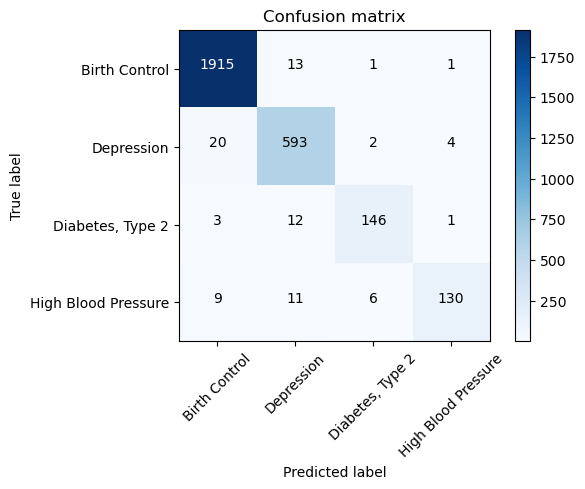

In [35]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.961
Confusion matrix, without normalization


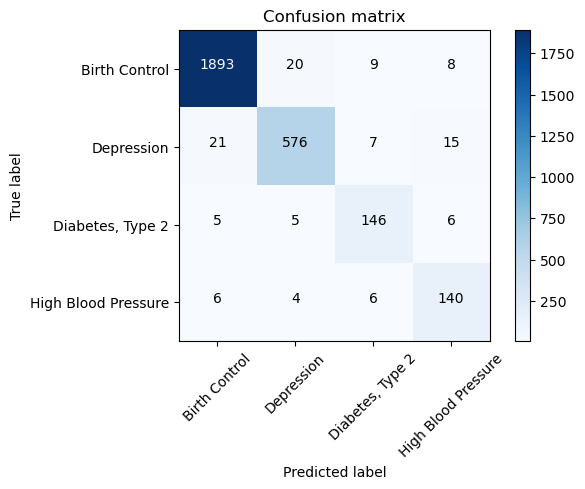

In [36]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

accuracy:   0.877
Confusion matrix, without normalization


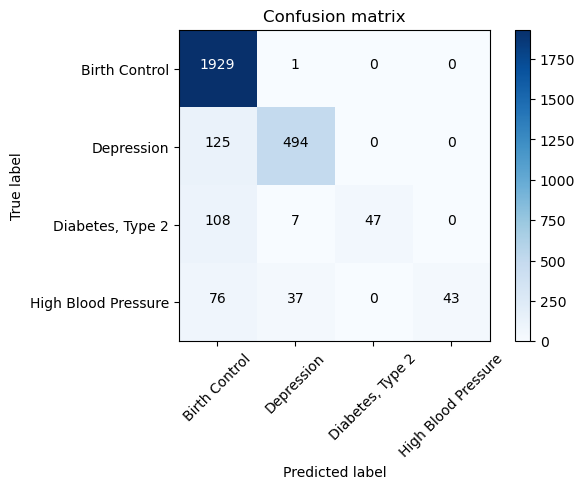

In [38]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model TFIDF

accuracy:   0.972
Confusion matrix, without normalization


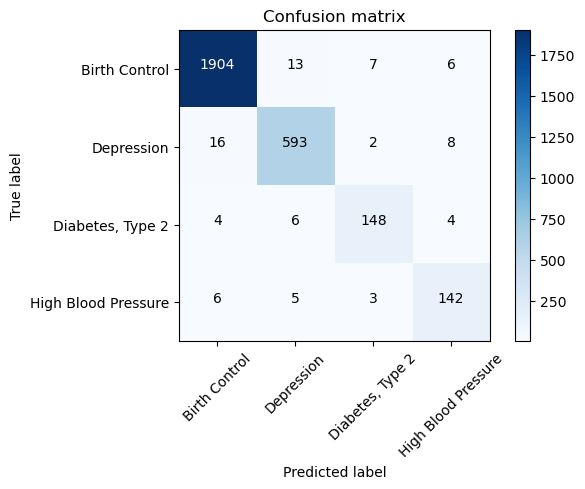

In [39]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF: Bigrams

In [40]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.974
Confusion matrix, without normalization


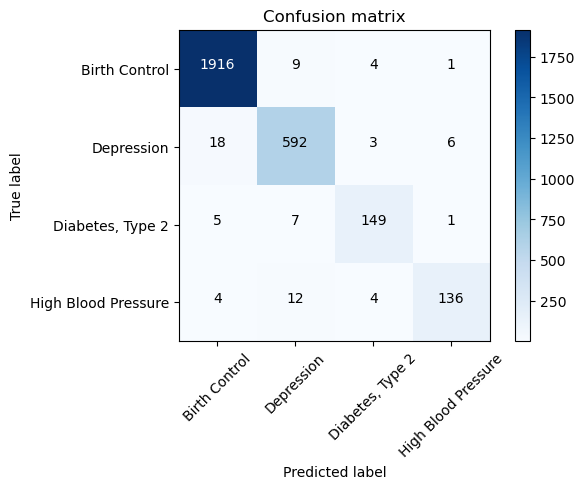

In [41]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## TFIDF : Trigrams

accuracy:   0.972
Confusion matrix, without normalization


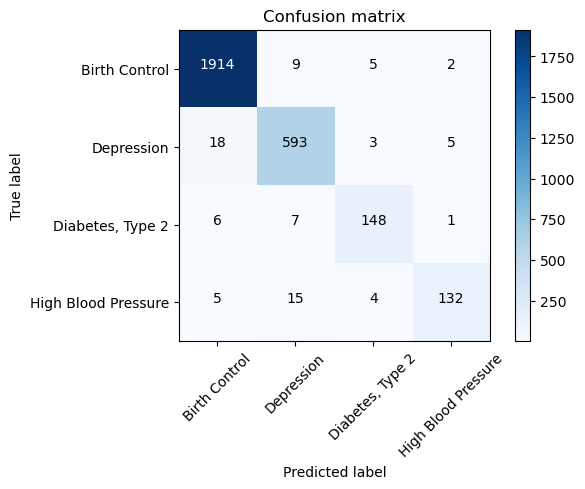

In [42]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Most important Features

In [43]:
# def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
#     labelid = list(classifier.classes_).index(classlabel)
#     feature_names = vectorizer.get_feature_names()
#     topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

#     for coef, feat in topn:
#         print (classlabel, feat, coef)



# most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
#     labelid = list(classifier.classes_).index(classlabel)
#     feature_names = vectorizer.get_feature_names()  # Correct method name is get_feature_names()
#     topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

#     print(f"Top {n} most informative features for class '{classlabel}':")
#     for coef, feat in topn:
#         print(feat, coef)

# # Example usage
# most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    print(f"Top {n} most informative features for class '{classlabel}':")
    for coef, feat in topn:
        print(feat, coef)

# Example usage
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')



Top 10 most informative features for class 'Birth Control':
prinivil 0.3593472527237288
etonogestrel 0.3915157644731833
loud 0.40368865901804823
lo 0.4177206711499856
benazapril 0.4418777685070237
immediately 0.443928740576517
cancelling 0.5091038836977737
lostrin 0.5989427460220501
bpd 0.7934216760693477
detrimental 5.045107392653072


In [44]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Top 10 most informative features for class 'Depression':
precious 0.5397154387544018
arthritis 0.5716537388690653
mindfulness 0.5876021270842673
somewhat 0.5919684009060099
sparked 0.6161959329793179
spin 0.6440097120935411
knot 0.7212899037357242
allowed 0.7420803308428832
amylase 1.0317505846016168
advance 2.4467702690557767


In [45]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

Top 10 most informative features for class 'High Blood Pressure':
backsliding 0.39916582982045534
daw 0.41040643405504695
dawn 0.41040643405504695
immediately 0.41196913009628644
arsenal 0.45544259044982327
demeanor 0.5393289129893706
microginon 0.564341583044887
court 0.7105752472850012
coupon 0.7870179241259636
delivered 0.8152174336604626


In [46]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Top 10 most informative features for class 'Diabetes, Type 2':
possiblility 0.3080264436665755
ppne 0.3165602771243343
toe 0.36670259857521786
sailing 0.4245908040659325
seed 0.4330773395437711
todo 0.4837619619149496
job 0.5520199789421547
jittery 0.6968595541954234
sedentery 1.0124893618671165
jell 1.6914516941083022


## Sample Predictions

In [47]:
X.tail()

condition  \
53732     Depression   
53741  Birth Control   
53759  Birth Control   
53760  Birth Control   
53763  Birth Control   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  \
53732                                         I&#039;m a 19 year old girl and I&#039;ve been suffering from major depression and social anxiety for the past 5 years. I finally went to the doctors and was prescribed Lexapro 10mg. I&#039;ve been on it for 4 days now. I had side effects the first day I took it - nausea, slight headache, slight dizziness, sleepy and yawning a lot and most annoyingly INSOMNIA! I even felt a little confused at bedtime while trying to sleep. The side effects lasted for the first 3 days, now they&#039;re slowly going away. The first day I was really hyper and the next I was so tired but now it&#039;s starting to balance out and I can sleep better. I haven&#039;t had a depressing day since I&#039;ve been taking Lexapro so lets hope it stays that way.   
53741    I first would like to thank all of you that posted comments. After reading them, I felt I&#039;m not alone. It&#039;s not just happening to me, there is nothing wrong with me. I&#039;m 34, with one child and had Mirena for 5 months. The insertion was almost painless and the first month was fine. Right now, I have gained 10lbs, loss of sex drive, have headaches, back pain, insomnia, constipation, hair loss and general depression - OF COURSE that&#039;s going to cause to have mood swings. I&#039;m waiting on an appointment to have it removed. ANOTHER IMPORTANT ASPECT is that I had suffered from postpartum depression after the birth of my child 4 years ago and honestly I was worried that these side effects (especially  depression) were a sign that I was still not okay.   
53759                                                                    I was on Microgestin for about 3 years. Over the past year, I started to get extremely bad headaches during the sugar pill week. I took extra strength Tylenol the entire week, twice a day, and it still didn&#039;t make my headaches go away. I also would feel very lightheaded and nauseous. I had to leave work early, it was bad. The only good thing was I&#039;ve had the same box of tampons for the entire year. I barely had a period. Oh yeah, I also got high pigmentation right above my lips. They call it a &quot;pregnancy mask&quot; but you can get it with certain birth control. It is very dark and it is difficult to hide with makeup! I&#039;m not a big fan of having a weird skin mustache so I went off it.   
53760                                                                                                                                                                                                                                                                                                         I started taking Apri about 7 months ago. My breats got noticeably larger within the first few weeks and I gained about 10 pounds, but I&#039;m a thin girl anyway so I gladly take on the extra few pounds and curves. I got prescribed this birth control because of my ovarian cysts and since I have not had any problems with them. They&#039;ve been unnoticeable and my cramps don&#039;t even exist anymore. I l

In [48]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer3.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'High Blood Pressure'

In [49]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer3.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Depression'

In [50]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer3.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Diabetes, Type 2'

In [51]:
import pickle
with open('disease_condition_reviews.pkl','wb') as f:
    pickle.dump(pass_tf,f)

with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer3, file)